In [58]:
import os
import matplotlib.pyplot as plt
import jax.numpy as jnp 
import jax 
import equinox as eqx
import optax
import jax.tree_util as jtu
import random
from jaxtyping import Array, Float, Int, PyTree

In [59]:
IMAGE_SIZE = 64
BATCH_SIZE = 16
BATCH_COUNT = 32
LATENT_DIMS = 64

Lets load some images.

In [60]:
def load_data(path : str, count : int):
    # load all images from this path
    images = []
    i = 0
    for file in os.listdir(path):
        i += 1
        if i > count:
            break
        if file.endswith(".jpg"):
            images.append(plt.imread(os.path.join(path, file)))

    return images


def preprocess(images : list, size : int, batch_size : int, batch_count : int):
    images = [jax.image.resize(image, (size, size, 3), method="linear") for image in images]
    images = jnp.array(images)
    images = images / 255.0

    batches = images.reshape((batch_count, batch_size, size, size, 3))
    batches = jnp.transpose(batches, (0, 1, 4, 2, 3))

    return batches

images_raw = load_data("data", count=BATCH_SIZE * BATCH_COUNT)
random.shuffle(images_raw)
batches = preprocess(images_raw, size=IMAGE_SIZE, batch_size=BATCH_SIZE, batch_count=BATCH_COUNT)

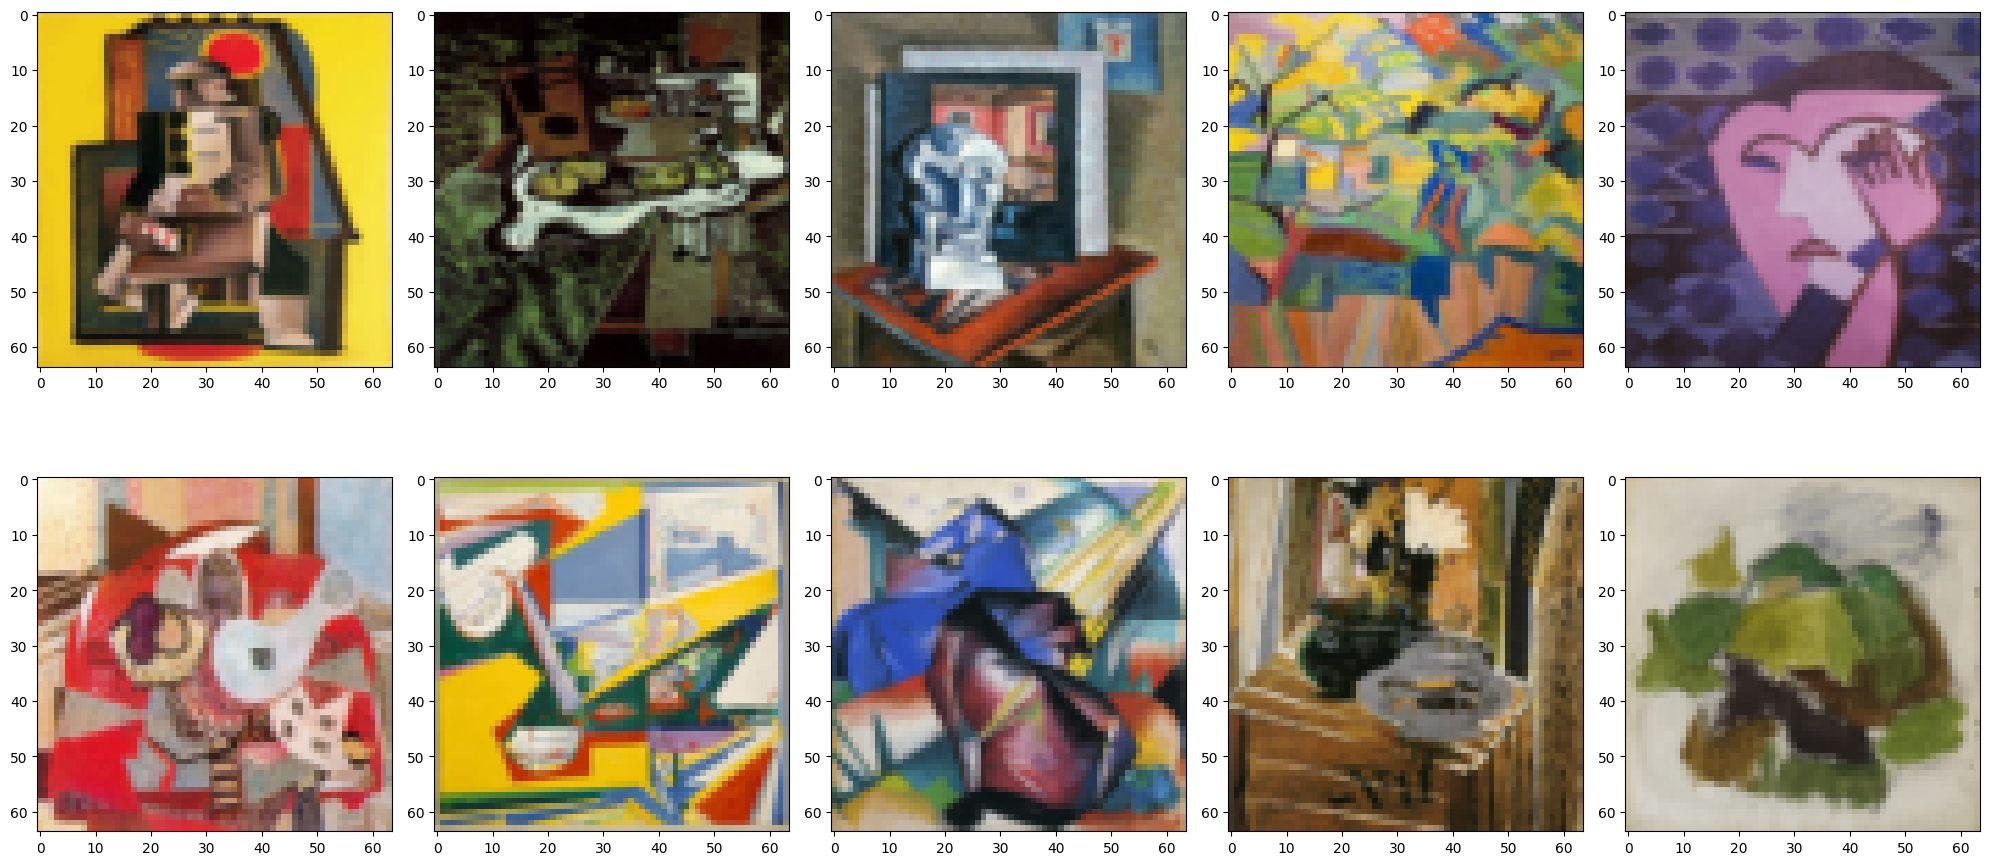

In [61]:
# generate 5 plots in a row
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i in range(5):
    axs[0, i].imshow(jnp.transpose(batches[0, i], (1, 2, 0)))
    axs[1, i].imshow(jnp.transpose(batches[1, i], (1, 2, 0)))

# tight layout
plt.tight_layout()

In [70]:
class Generator(eqx.Module):
    layers : list
    
    def __init__(self, 
            key, 
            latent_dim : int, 
            output_dim : int, 
            hidden_dim : int,
            n_channels : int):
    

        if jnp.sqrt(latent_dim) % 1 != 0:
            raise ValueError("latent_dim must be a perfect square")
        
        latent_sqrt = jnp.sqrt(latent_dim).astype(jnp.int32)

        # evaluate number of upscaling layers we need to get to the output_dim
        dim = latent_sqrt
        upscaling_layers = 0
        while dim < output_dim:
            dim *= 2
            upscaling_layers += 1

        print(f"upscaling layers: {upscaling_layers}")
        print(f"hidden size: {hidden_dim}")

        keys = jax.random.split(key, upscaling_layers + 1)

        # first layer maps latent vector to a grid of size hidden_size x latent_sqrt x latent_sqrt
        self.layers = [
            eqx.nn.Linear(
                key=keys[0],
                in_features=latent_dim,
                out_features=latent_dim * hidden_dim),
            jax.nn.leaky_relu,
            lambda x: jnp.reshape(x, (hidden_dim, latent_sqrt, latent_sqrt))]

        for i in range(upscaling_layers):
            self.layers.append(
                eqx.nn.ConvTranspose(
                    key=keys[i + 1],
                    num_spatial_dims=2,
                    in_channels=hidden_dim,
                    out_channels=hidden_dim,
                    kernel_size=4,
                    padding=1,
                    stride=2))
            self.layers.append(jax.nn.leaky_relu)

        # we add another conv without stride to get to the desired output_dim
        self.layers.append(
            eqx.nn.ConvTranspose(
                key=keys[-1],
                num_spatial_dims=2,
                in_channels=hidden_dim,
                out_channels=n_channels,
                kernel_size=3,
                padding=1,
                stride=1))
        
        self.layers.append(jax.nn.tanh)

    def __call__(self, z : Float[Array, "LATENT_DIM"]):
        for layer in self.layers:
            z = layer(z)
        return z

In [71]:
class Critic(eqx.Module):
    layers : list

    def __init__(self, 
        key,
        input_dim : int, 
        n_channels : int):

        dim = input_dim
        downscaling_layers = 0
        while dim > 2:
            dim = dim // 2
            downscaling_layers += 1

        print(f"downscaling layers: {downscaling_layers}")

        keys = jax.random.split(key, downscaling_layers + 2)

        self.layers = []

        self.layers.append(
            eqx.nn.Conv(
                key=keys[0],
                num_spatial_dims=2,
                in_channels=n_channels,
                out_channels=16,
                kernel_size=3,
                padding=1,
                stride=1))
        self.layers.append(jax.nn.leaky_relu)

        for i in range(downscaling_layers):
            self.layers.append(
                eqx.nn.Conv(
                    key=keys[i+1],
                    num_spatial_dims=2,
                    in_channels=16,
                    out_channels=16,
                    kernel_size=3,
                    padding=1,
                    stride=2))
            self.layers.append(jax.nn.leaky_relu)

        self.layers.append(
            lambda x: jnp.reshape(x, (2 * 2 * 16,)))
        self.layers.append(
            eqx.nn.Linear(
                key=keys[-1],
                in_features=16 * 2 * 2,
                out_features=1))
        
    def __call__(self, x : Float[Array, "3 IMAGE_SIZE IMAGE_SIZE"]):
        for layer in self.layers:
            x = layer(x)
        return x

In [72]:
def count_parameters(model: eqx.Module):
    return  sum(p.size for p in jtu.tree_leaves(eqx.filter(model, eqx.is_array)))

In [88]:
key = jax.random.PRNGKey(0)
key, gen_key, crit_key = jax.random.split(key, 3)

generator = Generator(
    key=gen_key,
    latent_dim=LATENT_DIMS,
    output_dim=IMAGE_SIZE,
    hidden_dim=8,
    n_channels=3)

print(f"Generator parameters: {count_parameters(generator)}")

critic = Critic(
    key=crit_key,
    input_dim=IMAGE_SIZE,
    n_channels=3)

print(f"Critic parameters: {count_parameters(critic)}")


upscaling layers: 3
hidden size: 8
Generator parameters: 36595
downscaling layers: 5
Critic parameters: 12113


In [89]:
key, noise_key = jax.random.split(key, 2)
input_data = jax.random.normal(noise_key, (LATENT_DIMS, ))
output_data = generator(input_data)

critic_value = critic(output_data)

assert output_data.shape == (3, IMAGE_SIZE, IMAGE_SIZE)
assert critic_value.shape == (1,)


In [90]:
def generate_images(key, generator : Generator, count : int, latent_dims : int):
    z = jax.random.normal(key, (count, latent_dims))
    return jax.vmap(generator)(z)

def generator_loss_fn(
    generator : Generator, 
    key,
    critic : Critic):

    generated_images = generate_images(key, generator, BATCH_SIZE, LATENT_DIMS)
    critic_vals = jax.vmap(critic)(generated_images)

    loss = -jnp.mean(jnp.log(jax.nn.sigmoid(critic_vals)))

    return loss

def critic_loss_fn(
    critic : Critic, 
    key,
    generator : Generator, 
    real_images : Float[Array, "BATCH_SIZE 3 IMAGE_SIZE IMAGE_SIZE"]):

    generated_images = generate_images(key, generator, BATCH_SIZE, LATENT_DIMS)

    critic_vals_generated = jax.vmap(critic)(generated_images)
    critic_vals_real = jax.vmap(critic)(real_images)

    generated_loss = optax.sigmoid_binary_cross_entropy(critic_vals_generated, jnp.zeros_like(critic_vals_generated))
    real_loss = optax.sigmoid_binary_cross_entropy(critic_vals_real, jnp.ones_like(critic_vals_real))

    loss = (jnp.mean(generated_loss) + jnp.mean(real_loss)) / 2

    return loss

In [91]:
@eqx.filter_jit
def update_step(
    key,
    generator : Generator,
    critic : Critic,
    generator_optimizer : optax.GradientTransformation,
    critic_optimizer : optax.GradientTransformation,    
    generator_optimizer_state : optax.OptState,
    critic_optimizer_state : optax.OptState,
    batch : Float[Array, "BATCH_SIZE 3 IMAGE_SIZE IMAGE_SIZE"]):

    critic_key, generator_key = jax.random.split(key, 2)

    critic_loss, critic_grads = eqx.filter_value_and_grad(critic_loss_fn)( 
        critic, 
        critic_key,
        generator, 
        batch)
    
    # print(f"critic grad: {critic_grads}")
    
    critic_update, new_critic_optimizer_state =\
        critic_optimizer.update(critic_grads, critic_optimizer_state)
    new_critic = eqx.apply_updates(critic, critic_update)

    generator_loss, generator_grads = eqx.filter_value_and_grad(generator_loss_fn)(        
        generator,
        generator_key,
        critic)
    
    generator_update, new_generator_optimizer_state =\
        generator_optimizer.update(generator_grads, generator_optimizer_state)
    
    new_generator = eqx.apply_updates(generator, generator_update)

    return new_generator, new_critic, new_generator_optimizer_state, new_critic_optimizer_state, generator_loss, critic_loss
    

In [92]:
optimizer_critic = optax.adam(1e-5)
optimizer_generator = optax.adam(1e-5)

optimizer_critic_state = optimizer_critic.init(eqx.filter(critic, eqx.is_array))
optimizer_generator_state = optimizer_generator.init(eqx.filter(generator, eqx.is_array))

num_epochs = 1000

critic_losses = []
generator_losses = []
for epoch in range(num_epochs):

  epoch_loss_critic = 0.0
  epoch_loss_generator = 0.0

  for i in range(len(batches)):
    generator, critic, optimizer_generator_state, optimizer_critic_state, generator_loss, critic_loss = update_step(
      key, 
      generator, 
      critic,
      optimizer_generator,
      optimizer_critic,
      optimizer_generator_state,
      optimizer_critic_state,
      batches[i])
    
    critic_losses.append(critic_loss)
    generator_losses.append(generator_loss)

    epoch_loss_critic += critic_loss
    epoch_loss_generator += generator_loss

  print(f"Epoch {epoch} - Critic loss: {epoch_loss_critic / len(batches)} - Generator loss: {epoch_loss_generator / len(batches)}")
  

Epoch 0 - Critic loss: 22.209287643432617 - Generator loss: 20.828777313232422
Epoch 1 - Critic loss: 22.206668853759766 - Generator loss: 20.854095458984375
Epoch 2 - Critic loss: 22.204133987426758 - Generator loss: 20.87791633605957
Epoch 3 - Critic loss: 22.201353073120117 - Generator loss: 20.900617599487305
Epoch 4 - Critic loss: 22.197980880737305 - Generator loss: 20.92246437072754
Epoch 5 - Critic loss: 22.193822860717773 - Generator loss: 20.944156646728516
Epoch 6 - Critic loss: 22.18865394592285 - Generator loss: 20.966590881347656
Epoch 7 - Critic loss: 22.18239402770996 - Generator loss: 20.990678787231445
Epoch 8 - Critic loss: 22.174654006958008 - Generator loss: 21.01662254333496
Epoch 9 - Critic loss: 22.16497802734375 - Generator loss: 21.04360008239746
Epoch 10 - Critic loss: 22.152589797973633 - Generator loss: 21.07398796081543
Epoch 11 - Critic loss: 22.136560440063477 - Generator loss: 21.106155395507812
Epoch 12 - Critic loss: 22.11428451538086 - Generator loss

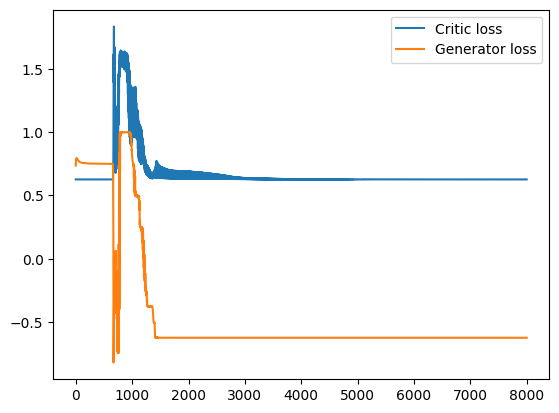

In [19]:
# plot the losses
plt.plot(critic_losses)
plt.plot(generator_losses)
plt.legend(["Critic loss", "Generator loss"])
plt.show()

(5, 3, 64, 64)


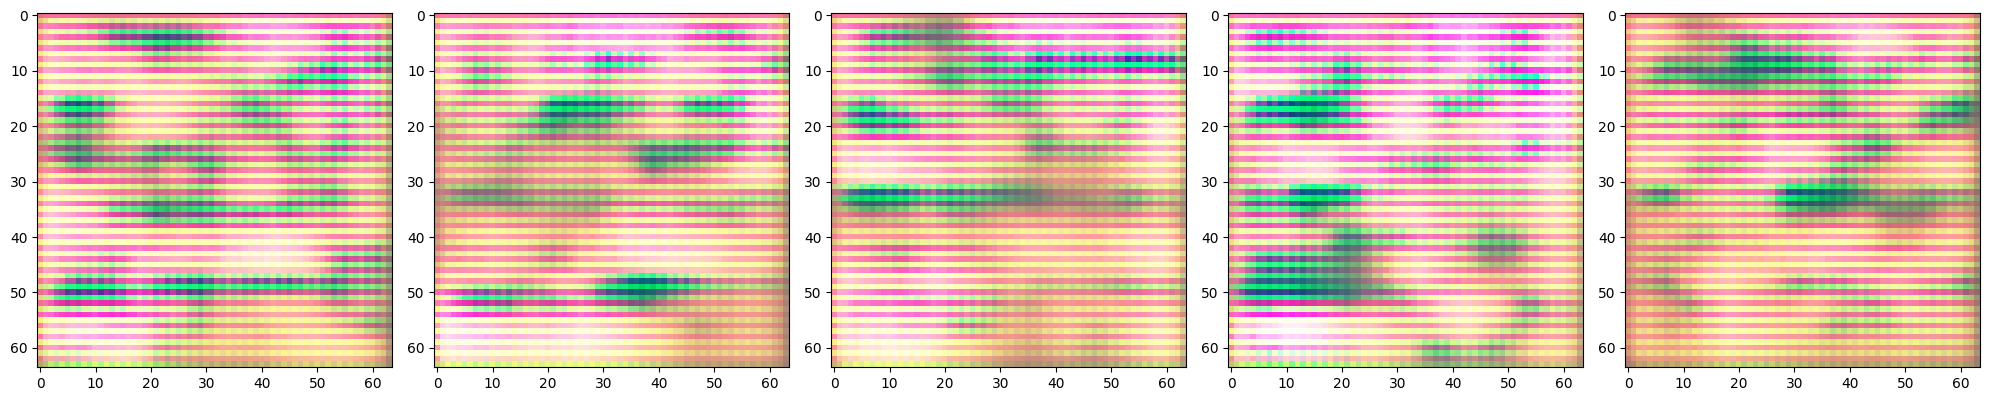

In [93]:
# generate some images
images = generate_images(key, generator, 5, LATENT_DIMS)
print(images.shape)
# normalize images

fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    img = jnp.transpose(images[i], (1, 2, 0))
    # normalize image
    img = (img - jnp.min(img)) / (jnp.max(img) - jnp.min(img))
    axs[i].imshow(img)
plt.tight_layout()
